In [10]:
import torch 
import torch.nn as nn 
from torch.optim import SGD
import numpy as np 
import matplotlib.pyplot as plt 
import time 

Suppose one has data that consists of an independent vector and a dependent vector $x_i$ and $y_i$ (i is the i'th value  in the data set ) .For example :

   * $x_i$ is the height of the th person, and  is their weight (predict weight using height)
   * $x_i$ is a picture of a handwritten digit, and  is the digit itself (predict numbers from hand written numbers)
   * $x_i$ is a CT scan of a patient, and  are the corresponding pixels corresponding to tumours (my research)
   
The goal of a neural network is as follows. Define a function $f$  that depends on parameters  that makes predictions   
                                                $$\hat{y_i} = f(x_i;a)$$
One wants to make  $y_i$ (the predictions) and $y_i$ (the true values) as close as possible by modifying the values of a. What does as close as possible mean? This depends on the task. In general, one defines a similarity function (or Loss function) $L(y,\hat{y})$. The more similar all the $y_i$s and $\hat{y_i}$s are, the smaller  should be. For example , this could be as simple as                                                
$$L(y,\hat{y}) = \sum_i(y_i-\hat{y_i})^2$$

In [11]:
x = torch.tensor([[6,2],[5,2],[1,3],[7,6]]).float()
y = torch.tensor([1,5,2,5]).float()

In [12]:
x

tensor([[6., 2.],
        [5., 2.],
        [1., 3.],
        [7., 6.]])

*  $x_1 = (6,2),x_2=(5,2)$
*  $y_1 = 1,y_2 = 5$

We want to find a function $f$ that depends on parameters $a$ that lets us get from $x$ to $y$.

**Idea**

   1. First multiply each element in x by a $8 \times 2$  matrix (this is 16 parameters )
   2. Then multiply each element in x by a $1\times 8$ matrix (this is 8 parameters )
   
Define a matrix (takes in a 2d vector and returns a 8d vector).   
* **IMPORTANT: When the matrix is created, it is initially created with random values.**

In [13]:
M1 = nn.Linear(2,8,bias=False)  ## Not taking bias here i.e b is not here 
M1

Linear(in_features=2, out_features=8, bias=False)

If one passes in a vector $x$ (the dataset) where each element $x_i$ (an instance) is a 2d vector, $M$ will apply the same matrix multiplication to each element $x_i$.

In [14]:
M1(x)

tensor([[-3.0580, -0.7191,  3.2259, -3.3918, -0.1126,  1.7774, -0.2962, -2.0141],
        [-2.5387, -0.4994,  2.7067, -3.0371,  0.1139,  1.2807, -0.1369, -1.4844],
        [-0.4325,  0.6788,  0.6851, -2.2503,  1.6430, -1.3078,  0.8296,  1.2166],
        [-3.4615,  0.2592,  3.9663, -6.2740,  2.1535, -0.1318,  0.8631, -0.2154]],
       grad_fn=<MmBackward0>)

We can chain this with a second matrix  **M2**

In [15]:
M2 = nn.Linear(8,1, bias=False)
M2

Linear(in_features=8, out_features=1, bias=False)

In [16]:
M2(M1(x)) 

tensor([[1.4823],
        [1.3598],
        [1.2439],
        [3.1000]], grad_fn=<MmBackward0>)

M2(M1(x)) have extra dimension hence we apply squeeze() to get same shape

In [17]:
M2(M1(x)).squeeze()

tensor([1.4823, 1.3598, 1.2439, 3.1000], grad_fn=<SqueezeBackward0>)

In [18]:
y

tensor([1., 5., 2., 5.])

The weights of the matrices M1 and M2 consitute the weights **a**  of the network defined above. In order to optimize for these weights, we first construct our network **f** as follows:

In [19]:
class MyNeuralNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.Matrix1 = nn.Linear(2,8,bias=False)
        self.Matrix2 = nn.Linear(8,1,bias=False)
    def forward(self,x):
        x = self.Matrix1(x)
        x = self.Matrix2(x)
        return x.squeeze()

Constructing the network using a subclass of the nn.Module allows the parameters of the network to be conveniently stored. This will be useful later when we need to adjust them.

In [20]:
f = MyNeuralNet()

Pass in data to the network.

In [21]:
yhat = f(x)
yhat

tensor([-2.1668, -1.8191, -0.4687, -2.6758], grad_fn=<SqueezeBackward0>)

In [22]:
y

tensor([1., 5., 2., 5.])

## Now we are  adjusting $a$ so that $\hat{y}$ and $y$ are similar

Now we define the loss function $L$ , which provides a metric of similarity between $y$ and $\hat{y}$
. In this case, we will use the mean squared error loss function:

In [23]:
L = nn.MSELoss()
L(y,yhat)

tensor(30.3854, grad_fn=<MseLossBackward0>)

Confirming it is doing the same as the regular mean-squared error:

In [24]:
torch.mean((y-yhat)**2)

tensor(30.3854, grad_fn=<MeanBackward0>)

Note that $L$ depends on $a$, since our predictions $\hat{y}$
 depend on the parameters of the network a . In this sense, $L=L(a)$ . The main idea behind machine learning is to compute
 
 $$\frac{\partial L}{\partial a_i}$$
 
 for each parameter $a_i$ of the network . Then we adjust each parameter as follows 
 
 $$a_i \to a_i - l\frac{\partial L}{\partial a_i}$$
 where $l$ is the learning rate .
 
 The idea is to do this over and over again, until one reaches a minimum for $L$. This is called gradient descent.
 
 * Each pass of the full data set $x$ is called an epoch. In this case, we are evaluating $\frac{\partial L}{\partial a_i}$ on the entire dataset $x$ each time we iterate $a_i \to a_i - l\frac{\partial L}{\partial a_i}$ , so each iteration corresponds to an epoch.
 
The SGD(meaning stochastic gradient descent) takes in all model parameters $a$ along with the learning rate $l$

In [25]:
opt = SGD(f.parameters(), lr=0.001)

In [26]:
losses = []
for _ in range(50):
    opt.zero_grad() # flush previous epoch's gradient
    loss_value = L(f(x), y) #compute loss
    loss_value.backward() # compute gradient ; computes dloss/dx for every parameter x which has requires_grad=True
    opt.step() # Perform iteration using gradient above ; this thing updates the value of x using the gradient x.grad. For example, the SGD optimizer performs: x += -lr * x.grad
    losses.append(loss_value.item())

**Explaination:** loss.backward() computes dloss/dx for every parameter x which has requires_grad=True. These are accumulated into x.grad for every parameter x. In pseudo-code:

x.grad += dloss/dx
optimizer.step updates the value of x using the gradient x.grad. For example, the SGD optimizer performs:

x += -lr * x.grad
optimizer.zero_grad() clears x.grad for every parameter x in the optimizer. It’s important to call this before loss.backward(), otherwise you’ll accumulate the gradients from multiple passes.

If you have multiple losses (loss1, loss2) you can sum them and then call backwards once:

loss3 = loss1 + loss2
loss3.backward()

Text(0.5, 0, 'Epochs')

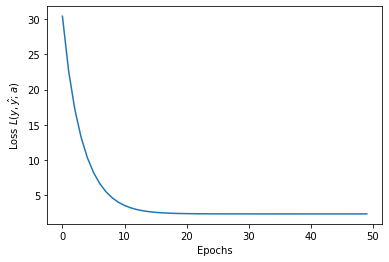

In [29]:
plt.plot(losses)
plt.ylabel('Loss $L(y,\hat{y};a)$')
plt.xlabel('Epochs')

This is as close as we can make the model  predict  from :

In [30]:
f(x)

tensor([2.8634, 2.5563, 1.8384, 5.2122], grad_fn=<SqueezeBackward0>)

In [31]:
y

tensor([1., 5., 2., 5.])